# Stocks to Use vs Price

Sample API script for modeling prices based on the stocks-to-use ratio

This script creates a basic CME price valuation model for corn and soybeans
using the US stocks-to-use ratio. Follow this [link](https://app.gro-intelligence.com/displays/gK9p5kadE) to a Gro public display containing the data series
used in this exercise. 


The stocks-to-use ratio is calculated each month as reported in the USDA's PS&D
database. The price variable is defined as the monthly average 'new crop' 
(December futures for corn and November futures for soybeans) price for the 
relevant report month. For example, the corn-June scatterplot will compare the US
stocks-to-use ratio from all June reports relative to the corresponding monthly 
average December corn futures price.

The output of this script will be a PDF file for each modeled crop, saved in
the current working directory. Each PDF will have 13 pages in total, 
including a scatterplot for each report month as well as a 
scatterplot summarizing the entire sample.


## Preliminary
First, we create a GroClient object and define entity ids for futures settlement prices and the United States region to save for future use. We also create a Python dictionary to define the correct new crop futures contract month for corn and soybeans.


In [14]:

import os
import calendar
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model

from api.client.gro_client import GroClient


API_HOST = 'api.gro-intelligence.com'
TOKEN    = os.environ['GROAPI_TOKEN']
client   = GroClient(API_HOST, TOKEN)

ref = {'corn':{'futures_contract_month':12},
       'soybeans':{'futures_contract_month':11}}

UNITED_STATES_REGION_ID = client.search_for_entity('regions', 'United States of America')
SETTLEMENT_PRICE_METRIC_ID = client.search_for_entity('metrics', 'futures prices settle (currency/mass)')
CME = client.search_for_entity('sources', 'CME')
PSD = client.search_for_entity('sources', 'PS&D')

## Define Data Functions

In these functions, we standardize and organize our data. First, we create a rolling futures price series. The series strings together contracts of the same monthly expiry over the full history of CME/CBOT trading. The function rolls the price to the following year after the near contract expires.

In [15]:
def contract_month_history(crop, contract_month):
    """full history of settlement prices for a specific commodity
    and month of expiry. e.g. December corn

    Parameters
    ----------
    crop : string
        'corn' or 'soybeans'
    contract_month : integer

    Returns
    -------
    pandas.Dataframe
    """
    market = client.search_for_entity('items', crop) 
    
    client.add_single_data_series({'metric_id': SETTLEMENT_PRICE_METRIC_ID, 
                                   'item_id': market, 
                                   'region_id': UNITED_STATES_REGION_ID, 
                                   'source_id': CME,
                                   'start_date': '2006-01-01',
                                   'show_revisions': True})
    
    df = client.get_df().sort_values(['end_date'])
    
    mkt_df = df.loc[(df.item_id == market) & (df.metric_id == SETTLEMENT_PRICE_METRIC_ID)]
    df_out = mkt_df.loc[mkt_df['end_date'].dt.month == contract_month].groupby(['reporting_date']).first()[['value', 'end_date']]

    return df_out

def get_price(crop):
    """calculates monthly average new crop CME price    

    Parameters
    ----------
    crop : string
        'corn' or 'soybeans'
    
    Returns
    -------
    pandas.Series
    """
    ct_mon = ref[crop.lower()]['futures_contract_month']
    
    px_hist = contract_month_history(crop, ct_mon)
    ts_out  = px_hist['value'].resample('M').mean().resample('D').fillna('bfill')
    ts_out.name = 'price'
    
    return ts_out

The next function calculates the annual stocks-to-use ratio for a given crop. Note that 'show_revisions' are set to True when the series is added to GroClient. This allows us to use the forecasted stocks-to-use ratio for each monthly PS&D report. For this exercise, we use stocks and demand estimates for the most forward-looking crop year available.

In [16]:
def get_stocks_to_use(crop, region=UNITED_STATES_REGION_ID):
    """Calculate historical carryout to use ratio for a given commodity  

    Parameters
    ----------
    crop : string
        'corn' or 'soybeans'
    Returns
    -------
    pandas.Series
    """
    crop_id = client.search_for_entity('items', crop)
    
    # add stocks series
    ENDING_STOCKS = client.search_for_entity('metrics', 'stocks, ending quantity (mass)')
    client.add_single_data_series({'metric_id': ENDING_STOCKS, 
                                   'item_id': crop_id, 
                                   'region_id': region, 
                                   'source_id': PSD, 
                                   'frequency_id': 9, 
                                   'start_date': '2006-12-31',
                                   'show_revisions': True})    
    
    
    # add consumption series
    CONSUMPTION = client.search_for_entity('metrics', 'domestic consumption (mass)')
    client.add_single_data_series({'metric_id': CONSUMPTION, 
                                    'item_id': crop_id, 
                                    'region_id': region, 
                                    'source_id': PSD, 
                                    'frequency_id': 9,
                                    'start_date': '2006-12-31',
                                    'show_revisions': True})

    df_pts = client.get_df()
    df_pts = df_pts.sort_values('end_date', ascending=True)
    df_grp = df_pts.groupby(['item_id', 'metric_id', 'reporting_date']).last()
    
    stocks = df_grp.loc[(crop_id, ENDING_STOCKS), :]['value']
    cons   = df_grp.loc[(crop_id, CONSUMPTION), :]['value']
    
    ts_out = stocks.div(cons)
    ts_out.name = 'stocks_to_use'
    
    return ts_out

## Define Analysis and Charting Functions
In the first function, we run a simple linear regression model on a pandas dataframe with columns of price and stocks-to-use ratio. The second function creates a scatterplot between the two variables. 

In [17]:
def run_regression(df):
    """run linear regression between stocks to use ratio and price  

    Parameters
    ----------
    df : pandas.DataFrame

    Returns
    -------
    float, float, float
        r-squared value, intercept, and x variable coefficient
    """
    lm = linear_model.LinearRegression()
    X  = df.loc[:, ['stocks_to_use']]
    
    lm.fit(X, df['price'])
    
    rsq = lm.score(X, df['price'])
    
    return rsq, lm.intercept_, lm.coef_[0]

The next function creates a scatterplot with price on the y-axis and the stocks-to-use ratio on the x-axis. 

In [18]:
def create_scatterplot(df_in, name, crop):
    """scatterplot vizualization for regression model

    Parameters
    ----------
    df_in : string
        'corn' or 'soybeans'
    name : int or string
        month of report being analyzed or 'all' for all months
    crop : string
        'corn' or 'soybeans'
    """    
    stu = df_in['stocks_to_use']
    px  = df_in['price']
    
    rsq, intercept, slope = run_regression(df_in)
    
    fig = plt.figure(figsize=(5, 5), dpi=100)
    ax  = fig.add_subplot(111)

    line = slope * stu.values + intercept
    
    if (type(name) is str):
        mon = name
    else:
        mon = calendar.month_abbr[name]
    
    ttl = '{}: {} Reports: rsq:{}'.format(crop.title(), mon, rsq.round(2))
    
    lbl = 'y={:.2f}x+{:.2f}'.format(slope, intercept)
    plt.plot(stu.values, line, 'r', label=lbl)

    plt.scatter(stu.values, px.values, color="k", s=3.5)
    plt.legend(fontsize=9)

    fig.suptitle(ttl, fontsize=12)
    ax.set_xlabel('Stocks to Use Ratio')
    ax.set_ylabel('Price')

    return fig

## Create PDF File of Scatterplots

Next, we run the code for corn and soybeans, and output the results to PDFs. We also print the scatterplots directly in the notebook for users who prefer to see the results in this format. Running the following section of code will require approximately 100,000 data points (~50,000 points for each crop run).

Added {'metric_id': 1470032, 'item_id': 274, 'region_id': 1215, 'source_id': 14, 'frequency_id': 9, 'start_date': '2006-12-31', 'show_revisions': True}
Added {'metric_id': 1480032, 'item_id': 274, 'region_id': 1215, 'source_id': 14, 'frequency_id': 9, 'start_date': '2006-12-31', 'show_revisions': True}
Added {'metric_id': 15820065, 'item_id': 274, 'region_id': 1215, 'source_id': 81, 'start_date': '2006-01-01', 'show_revisions': True}
C:\anaconda_directory\envs\python3\lib\site-packages\pandas\core\reshape\merge.py:946: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
Added {'metric_id': 1470032, 'item_id': 270, 'region_id': 1215, 'source_id': 14, 'frequency_id': 9, 'start_date': '2006-12-31', 'show_revisions': True}
Added {'metric_id': 1480032, 'item_id': 270, 'region_id': 1215, 'source_id': 14, 'frequency_id': 9, 'start_date': '2006-12-31', 'show_revisions': True}
C:\anaconda_directo

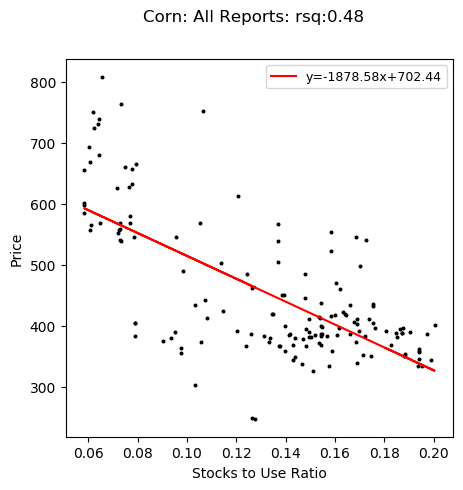

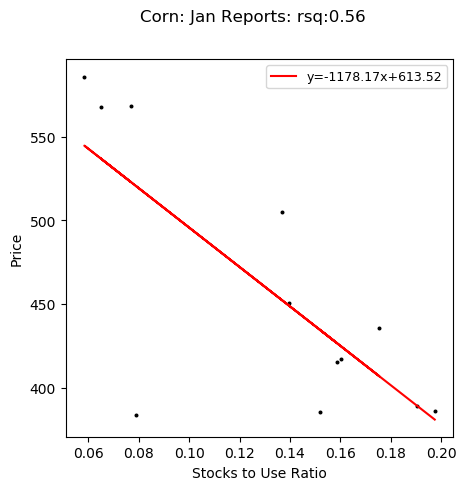

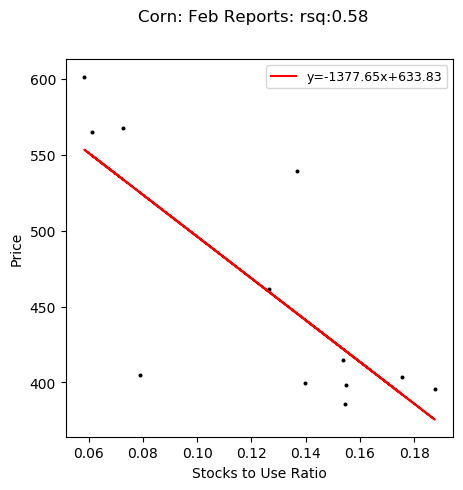

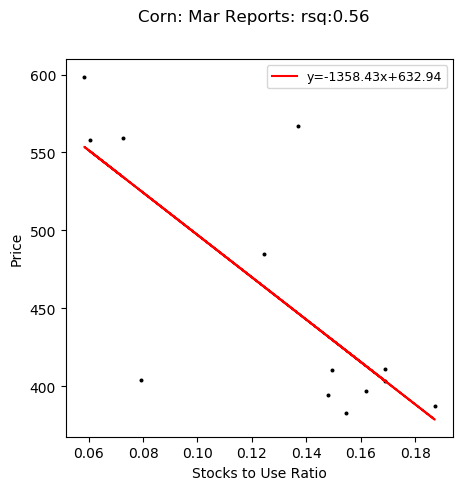

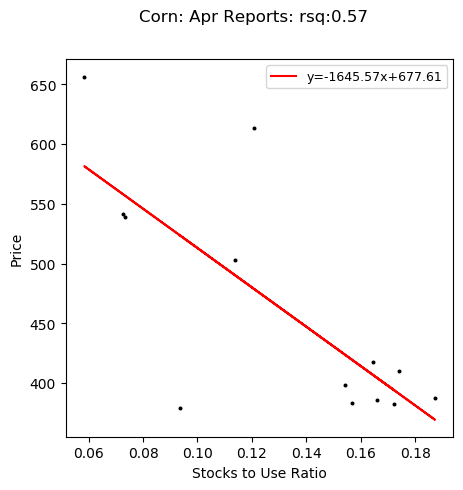

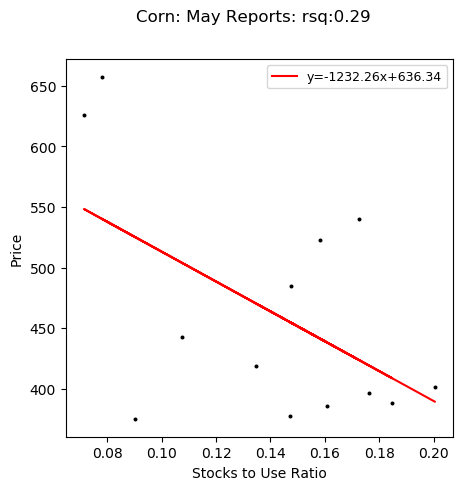

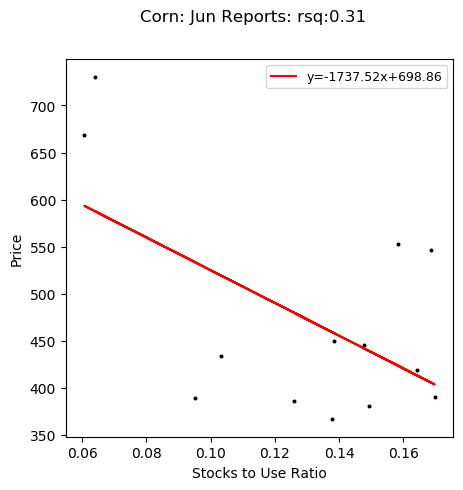

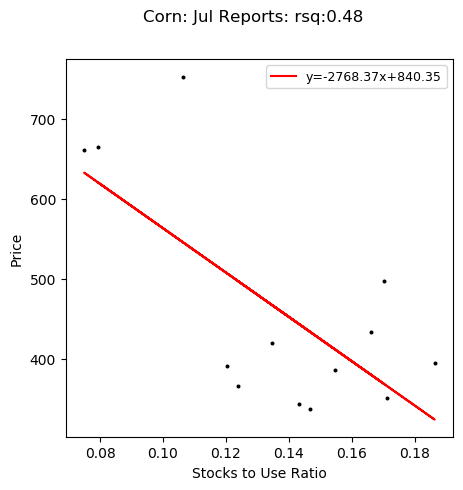

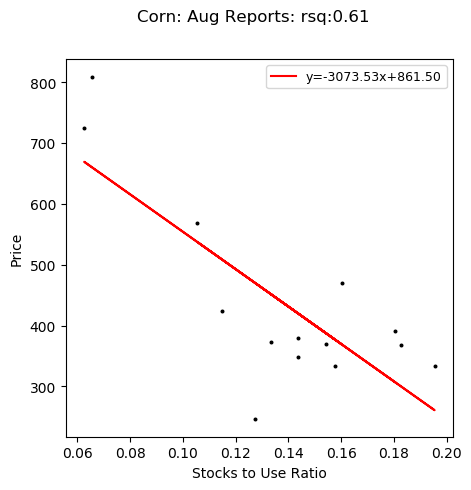

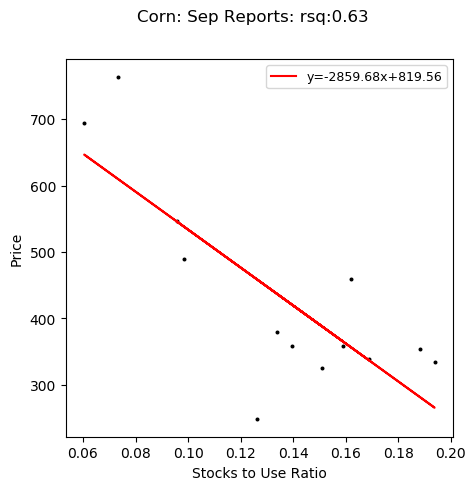

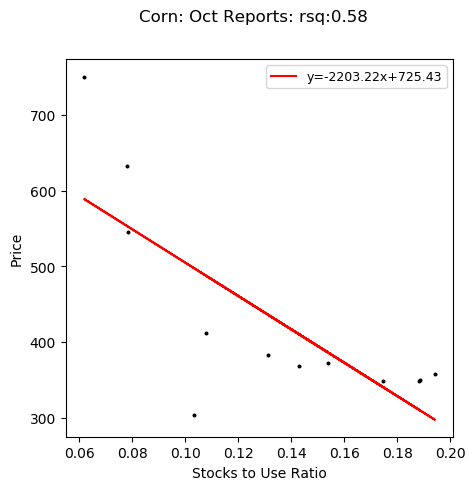

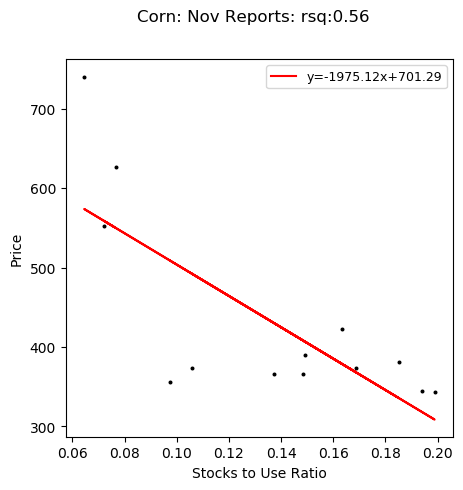

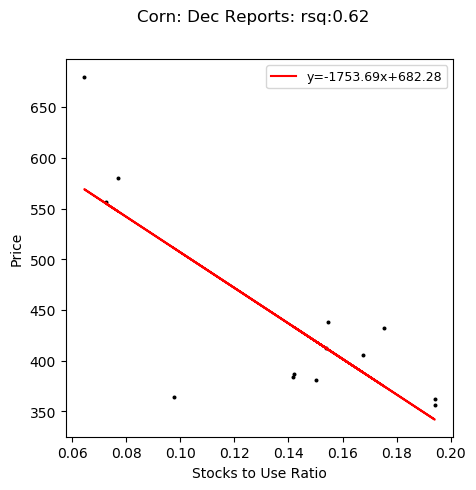

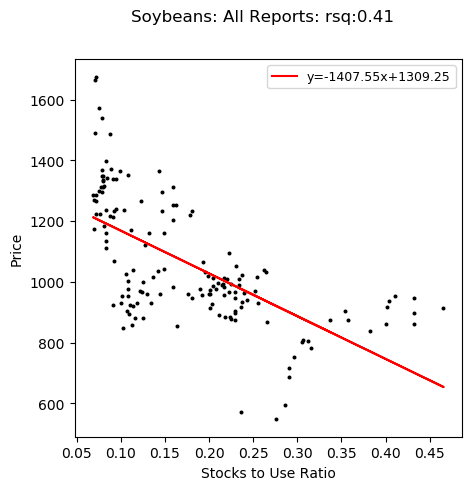

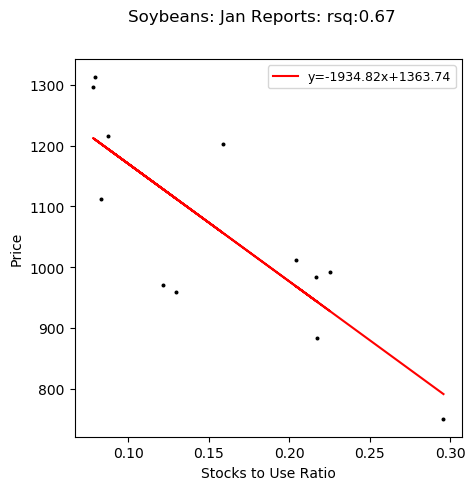

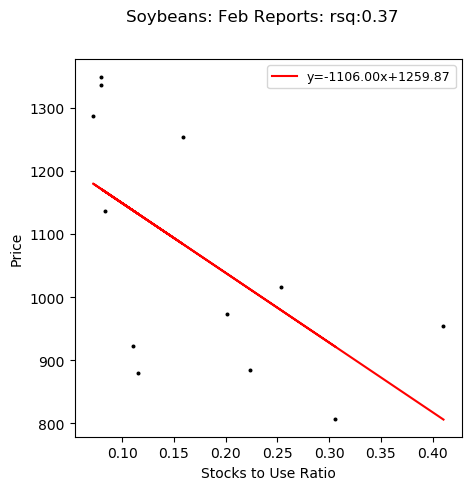

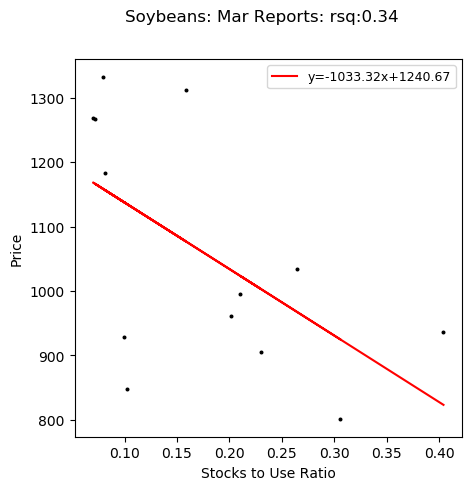

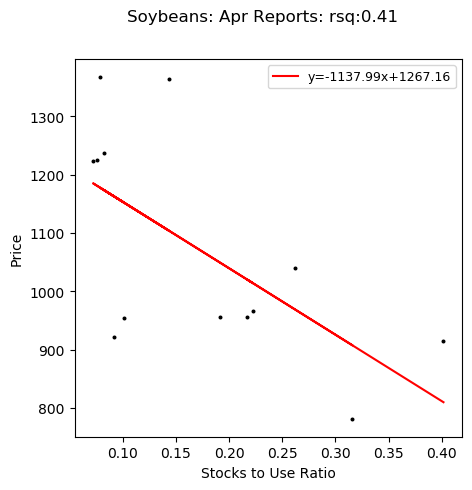

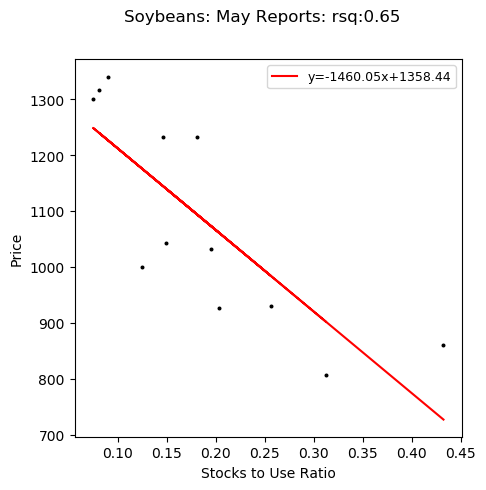

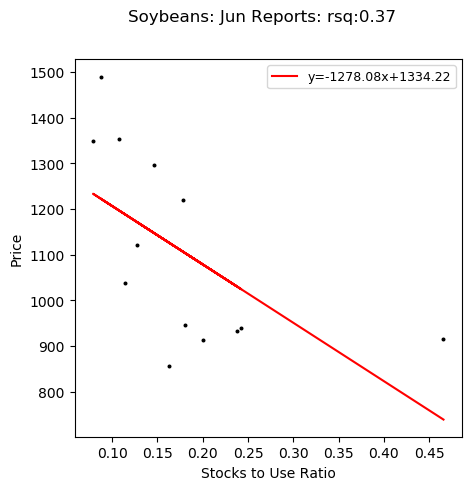

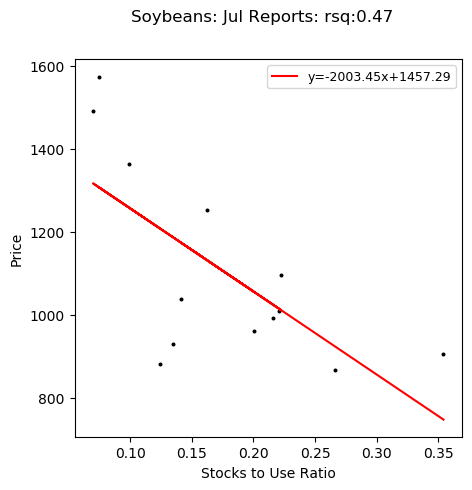

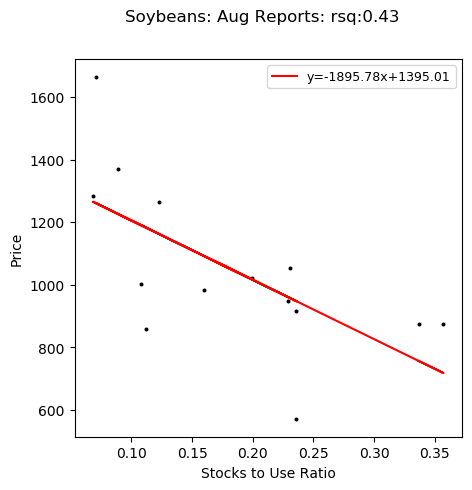

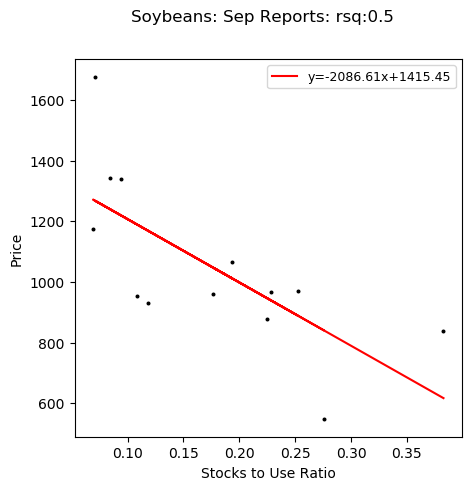

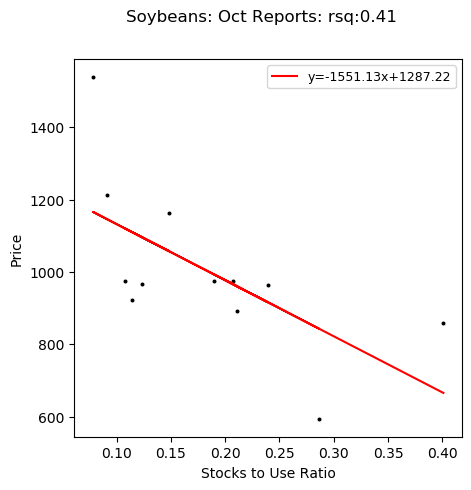

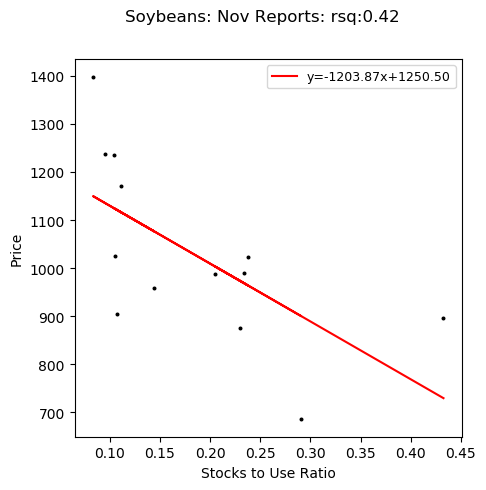

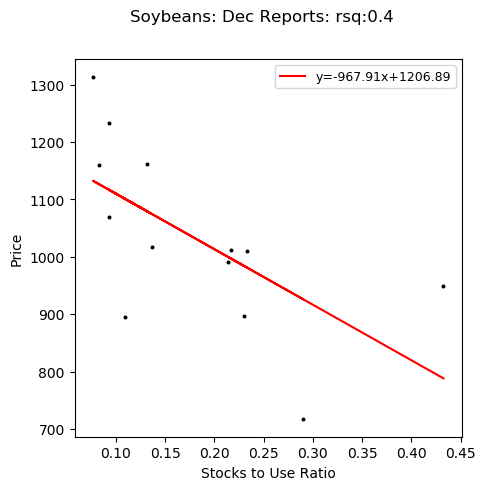

In [19]:
def write_price_model(crop):
    """run a regression between price and stocks to use for all WASDE report months,
       create a scatterplot of regression values, and write to PDF

    Parameters
    ----------
    crop : string
        'corn' or 'soybeans'

    """
    stu = get_stocks_to_use(crop)
    px  = get_price(crop)
    df  = pd.concat([stu, px], axis=1).dropna()
    
    grp = df.groupby(df.index.month)
        
    fig_lst = [create_scatterplot(df, 'All', crop)]
    fig_lst.extend([create_scatterplot(group, name, crop) for name, group in grp])

    fn = os.path.join(os.getcwd(), '{}.pdf'.format(crop))
    pp = PdfPages(fn)
    for f in fig_lst: pp.savefig(f)
    pp.close()
    

write_price_model('corn')
write_price_model('soybeans')